In [18]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sympy
from sympy import symbols, sympify, lambdify, compose, I, pi, log, exp, simplify
from sympy.abc import x
import time
from statistics import mean

In [19]:

# Extracción de datos

columna1 = []
columna2 = []
columna3 = []

with open('c:/Users/ximen/Desktop/Practicas DFI/hub_data_3.txt', 'r') as archivo:
    # Lee cada línea del archivo
    for linea in archivo: #cada linea es una fila del texto
        elementos = linea.split() # divide la línea en sus elementos utilizando espacios como delimitadores
        #print(elementos)
        columna1.append(elementos[0]) # Agrega cada elemento a su respectiva columna
        columna2.append(elementos[1])
        columna3.append(elementos[2])

z = np.zeros(len(columna1))
for i in range(len(columna1)):
  z[i] = float(columna1[i])

H = np.zeros(len(columna2))
for i in range(len(columna2)):
  H[i] = float(columna2[i])

desv = np.zeros(len(columna3))
for i in range(len(columna3)):
  desv[i] = float(columna3[i])

In [20]:
def Composicion(expresion1, expresion2):
    x = symbols('x')
    expresiones = [expresion1, expresion2]
    expresiones_sympy = [sympify(exp) for exp in expresiones] 
    f1 = expresiones_sympy[0]
    f2 = expresiones_sympy[1]
    # Se componen expresiones
    composicion = f1.subs(x, f2)
    return str(composicion)

In [21]:
def Simplificador(poblacion):
    x = symbols('x')
    expresiones_simplificadas = [simplify(expresion) for expresion in poblacion]
    return expresiones_simplificadas

In [22]:
def Creador(num_poblacion_inicial, poblacion_base, operaciones_base):

    Poblacion = []
    
    for n in range(0, num_poblacion_inicial):
        f1 = random.choice(poblacion_base)
        f2  = random.choice(poblacion_base)
        operador = random.choice(operaciones_base)

        if operador == 'comp':
            kid = Composicion(f1, f2)
            Poblacion.append(kid)
        else:
            kid= f"{f1} {operador} {f2}"
            Poblacion.append(kid)
    
    return Poblacion

In [23]:
def Calculador_Chi(Poblacion, z, H, desv):
    Chi = []
    x = symbols('x', real=True)
    expresiones_sympy = [sympify(exp) for exp in Poblacion]
    funciones_python = [lambdify(x, expresion, 'numpy') for expresion in expresiones_sympy]

    indices = []

    for n , funcion in enumerate(funciones_python):
        f = funcion(z)
        chi_value = np.sum(np.square((f - H) / desv))

        if not np.isinf(chi_value) and not np.isnan(chi_value):
            Chi.append(chi_value)
            indices.append(n)

    Chi_menor = min(Chi)
    indices = np.array(indices)
    Poblacion = np.array(Poblacion)

    poblacion_nueva = Poblacion[indices].tolist()

    return np.array(Chi), poblacion_nueva


In [24]:
def Reproductor(Funciones_seleccionadas, porcentaje_mutacion, poblacion_base, operaciones, cantidad_hijos): 

    # mantener la poblacion cte
    
    combinados = []

    for funcion in Funciones_seleccionadas:
        operaciones_para_combinacion = [random.choice(operaciones) for i in range(cantidad_hijos)]
        funciones_a_combinar = [random.choice(Funciones_seleccionadas) for i in range(cantidad_hijos)]
        for n in range(0, len(operaciones_para_combinacion)):
            if operaciones_para_combinacion[n] == 'comp':
                x = symbols('x')
                expresiones = [funcion, funciones_a_combinar[n]]
                expresiones_sympy = [sympify(exp) for exp in expresiones] 
                f1 = expresiones_sympy[0]
                f2 = expresiones_sympy[1]
                # Se componen expresiones
                composicion = f1.subs(x, f2)
                kid = str(composicion)
                combinados.append(str(kid))
            else: 
                kid = f"({funcion}) {operaciones_para_combinacion[n]} ({funciones_a_combinar[n]})"
                combinados.append(kid)
                
    combinados = np.array(combinados)

    # EMPIEZA MUTACION
    num_mutacion = int(len(combinados)*(porcentaje_mutacion/100))
    funciones_a_mutar = []
    mutaciones = []

    for n in range(0, num_mutacion): 
        expresion_m = random.choice(combinados)
        funciones_a_mutar.append(expresion_m)
        operacion = random.choice(operaciones)
        expresion2 = random.choice(poblacion_base)

        if operacion == 'comp':
            x = symbols('x')
            expresiones = [expresion_m, expresion2]
            expresiones_sympy = [sympify(exp) for exp in expresiones] 
            f1 = expresiones_sympy[0]
            f2 = expresiones_sympy[1]
            # Se componen expresiones
            composicion = f1.subs(x, f2)
            mutado = str(composicion)
            mutaciones.append(str(mutado))
        else: 
            expresion = f"({expresion_m}) {operacion} {expresion2}"
            mutaciones.append(expresion)

    indices_no_mutados = np.array([i for i, elem in enumerate(combinados) if elem not in funciones_a_mutar])
    funciones_sin_mutar = combinados[indices_no_mutados]
    funciones_sin_mutar = funciones_sin_mutar.tolist()
    mutaciones += funciones_sin_mutar 

    mutaciones = mutaciones
    
    return mutaciones

In [25]:
def Seleccionador(poblacion_inicial, Chi, porcentaje_seleccion):

    seleccion = np.percentile(Chi, porcentaje_seleccion)

    #print('Los chi son: ' + str(Chi))
    print('El chi menor fue: ' + str(min(Chi)))
    print('El chi MAYOR fue: ' + str(max(Chi)))
    print('La seleccion fue: ' + str(seleccion))

    Chi_seleccionados = Chi[Chi <= seleccion]
    indices = np.where(Chi <= seleccion)[0]
    funciones_seleccionadas = [poblacion_inicial[i] for i in range(len(Chi)) if Chi[i] <= seleccion]

    combined_data = list(zip(Chi_seleccionados, funciones_seleccionadas))

    # Ordena la lista combinada por los elementos de x
    sorted_combined_data = sorted(combined_data, key=lambda pair: pair[0])

    # Desempaqueta los resultados ordenados
    Chis, funciones = zip(*sorted_combined_data)

    Funciones_seleccionadas = list(funciones)

    Chi_menor = min(Chis)

    return Funciones_seleccionadas, Chi_menor

In [26]:
def GA(num_generaciones, num_poblacion_inicial, operaciones, poblacion_base, porcentaje_seleccion, porcentaje_mutacion, z, H, desv, numero_hijos):
    Poblacion = []
    Generaciones = []
    Chi_menor = []

    for n in range(0, num_generaciones):
        print('Número de Generación:' +str(n))
        if n == 0:
            C= Creador(num_poblacion_inicial, poblacion_base, operaciones)
            R = Reproductor(C, porcentaje_mutacion, poblacion_base, operaciones, numero_hijos)
            Cal = Calculador_Chi(R, z, H, desv)
            S = Seleccionador(Cal[1], Cal[0], porcentaje_seleccion)
            Generaciones.append(S[0])
            Chi_menor.append(S[1])
            print('LONGITUD GENERACION INCIAL: ' + str(len(Generaciones[0])))

        else:
            R = Reproductor(Generaciones[n-1], porcentaje_mutacion, poblacion_base, operaciones, numero_hijos)
            print('Se reproducen')
            Cal = Calculador_Chi(R, z, H, desv)
            print('Se calcula Chi')
            S = Seleccionador(Cal[1], Cal[0], porcentaje_seleccion)
            print('Seleccion')
            Generaciones.append(S[0])
            Chi_menor.append(S[1])
            print('LONGITUD GENERACION: ' + str(len(Generaciones[-1])))

    Generacion_Final = Simplificador(Generaciones[-1])
    
    return Generacion_Final, Chi_menor

In [27]:
import warnings

# Desactivar la advertencia de desbordamiento en potencias
warnings.filterwarnings("ignore", category=RuntimeWarning)

poblacion_base = ['(x+1)', 'x**x', '0.5']

operaciones_base = ['*', '+', '-', '/', 'comp']

GA = GA(13, 5, operaciones_base, poblacion_base, 20, 5, z, H, desv, 6)

Número de Generación:0
El chi menor fue: 3259.194269579979
El chi MAYOR fue: 144955.635969006
La seleccion fue: 4066.368526355225
LONGITUD GENERACION INCIAL: 6
Número de Generación:1
Se reproducen
Se calcula Chi
El chi menor fue: 2788.322606835488
El chi MAYOR fue: 1.0425621974178641e+183
La seleccion fue: 3798.2988228809686
Seleccion
LONGITUD GENERACION: 7
Número de Generación:2
Se reproducen
Se calcula Chi
El chi menor fue: 2651.383574267313
El chi MAYOR fue: 4.929483003024234e+268
La seleccion fue: 4180.241968693184
Seleccion
LONGITUD GENERACION: 8
Número de Generación:3
Se reproducen
Se calcula Chi
El chi menor fue: 2268.406479683214
El chi MAYOR fue: 1.8220519510168188e+87
La seleccion fue: 3331.9563402699137
Seleccion
LONGITUD GENERACION: 9
Número de Generación:4
Se reproducen
Se calcula Chi
El chi menor fue: 2804.1607765366552
El chi MAYOR fue: 376830935.644808
La seleccion fue: 4068.04641631332
Seleccion
LONGITUD GENERACION: 10
Número de Generación:5
Se reproducen
Se calcula Ch

In [ ]:
Chi = np.zeros(len(GA[0]))
x = symbols('x')
expresiones_sympy = [sympify(exp) for exp in GA[0]]

funciones_evaluadas = [lambdify(x, expr, 'numpy') for expr in expresiones_sympy]
valores_x_np = np.array(z)
H_np = np.array(H)
desv_np = np.array(desv)

for n, funcion_evaluada in enumerate(funciones_evaluadas):
    f = funcion_evaluada(valores_x_np)
    diferencia = (H_np - f)
    chi = np.sum((diferencia/desv_np)**2)
    Chi[n] = chi
seleccion = min(Chi)
seleccionados = Chi[Chi == seleccion]
indices = np.where(Chi == seleccion)[0]
funciones_seleccionadas = [GA[0][i] for i in indices]

print(funciones_seleccionadas)
print(len(funciones_seleccionadas))

funcion = lambdify(x, funciones_seleccionadas[0], 'numpy')

evaluada = funcion(z)

[12.0*x**2 + 24.0*x + 0.5*x**(2*x) + 3.5*x**x + 3.5*x**(x + 1) + 72.6512295432926]
1


Text(0.5, 1.0, 'Chi a lo largo de las generaciones')

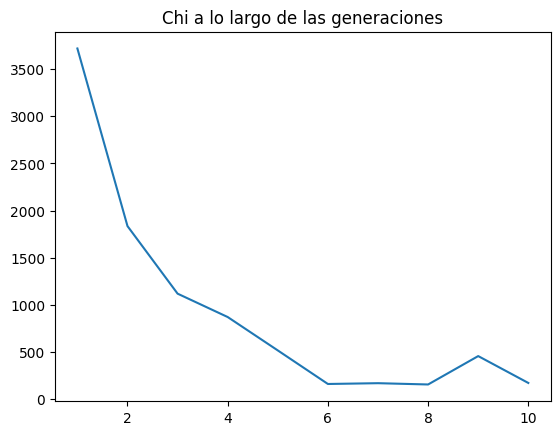

In [ ]:
Chi_menor = GA[1]

Gran_Chi = np.zeros(len(GA[1]))

Numero_generacion = np.zeros(len(GA[1]))

i = 1
for n in range(0, len(Chi_menor)):
    Numero_generacion[n] = i
    Gran_Chi[n] = (Chi_menor[n])
    i+=1

plt.plot(Numero_generacion, Gran_Chi)
plt.title('Chi a lo largo de las generaciones')

In [ ]:
def f1(x):
    return 12.0*x**2 + 24.0*x + 0.5*x**(2*x) + 3.5*x**x + 3.5*x**(x + 1) + 72.6512295432926

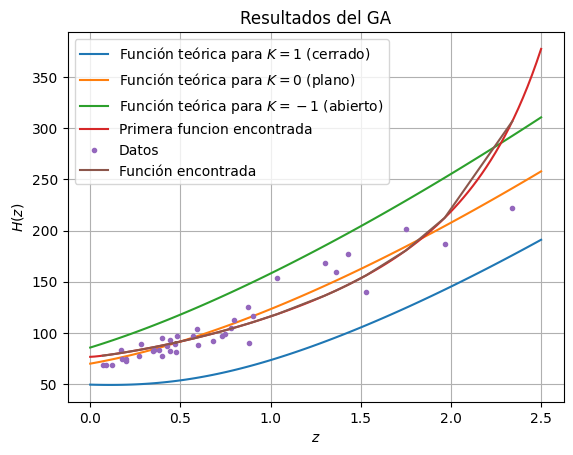

In [ ]:
def H_bm(z, Omega_r, Omega_m, Omega_lambda, omega_DE, Omega_0): 
    return H_0*np.sqrt((Omega_r*(1+z)**(3*(1 + 1/3)) + Omega_m*(1+z)**3 + Omega_lambda*(1+z)**(3*(1+omega_DE)) + (1-Omega_0)*(1+z)**2))

H_0 = 70
O_r = 8.4*10**(-5)
O_m = 0.3
O_lambda = 0.7 - 8.4*10**(-5)
o_DE = -1
O_0 = [0.5, 1, 1.5]

# Se crea un arreglo de z para la función teórica
z_bu = np.linspace(0, 2.5, 100)

# hub_data_3.txt
H_teorico_plano = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[1])
H_teorico_cerrado = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[2])
H_teorico_abierto = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[0])

plt.plot(z_bu, H_teorico_cerrado, label = 'Función teórica para $K = 1$ (cerrado)')
plt.plot(z_bu, H_teorico_plano, label = 'Función teórica para $K = 0$ (plano)')
plt.plot(z_bu, H_teorico_abierto, label = 'Función teórica para $K = -1$ (abierto)')
plt.plot(z_bu, f1(z_bu), label = 'Primera funcion encontrada')


plt.plot(z, H, '.', label = 'Datos')
plt.plot(z, evaluada, label = 'Función encontrada')
plt.legend()
plt.xlabel('$z$')
plt.ylabel('$H(z)$')
plt.title('Resultados del GA')
plt.grid(True)
plt.show()